# Background

In this homework we will extract interesting information from www.topuniversities.com and www.timeshighereducation.com, two platforms that maintain a global ranking of worldwide universities. This ranking is not offered as a downloadable dataset, so you will have to find a way to scrape the information we need! You are not allowed to download manually the entire ranking -- rather you have to understand how the server loads it in your browser. For this task, Postman with the Interceptor extension can help you greatly. We recommend that you watch this brief tutorial to understand quickly how to use it.

In [1]:
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import re
import types
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# number of universities to fetch
n = 200
tu_link = "https://www.topuniversities.com"

# 1. Obtain the 200 top-ranking universities in www.topuniversities.com

When loading the page https://www.topuniversities.com/university-rankings/world-university-rankings/2018, one can notice, that several additional requests are sent to the server. <br>
One of these files is a json file, which contains the complete ranking:
https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt?_=1508954434901. <br>

In [3]:
req_tu_ranking = requests.get(tu_link+'/sites/default/files/qs-rankings-data/357051.txt?_=1508168782318')
tu_ranking = req_tu_ranking.json()["data"]
#tu_ranking json take too much place so not printed

In [4]:
len(tu_ranking)

959

In [5]:
# check entries and equal ranks
print (tu_ranking[20])
print (tu_ranking[21])

{'nid': '294857', 'url': '/universities/university-michigan', 'title': 'University of Michigan', 'logo': '<img src="https://www.topuniversities.com/sites/default/files/university-of-michigan_403_small_0.jpg" alt="University of Michigan Logo">', 'core_id': '403', 'score': '87', 'rank_display': '=21', 'country': 'United States', 'cc': 'US', 'region': 'North America', 'stars': '5', 'guide': '<a href="/where-to-study/north-america/united-states/guide" class="guide-link" target="_blank">United States</a>'}
{'nid': '294490', 'url': '/universities/duke-university', 'title': 'Duke University', 'logo': '<img src="https://www.topuniversities.com/sites/default/files/duke-university_168_small_0.jpg" alt="Duke University Logo">', 'core_id': '168', 'score': '87', 'rank_display': '=21', 'country': 'United States', 'cc': 'US', 'region': 'North America', 'stars': '5', 'guide': '<a href="/where-to-study/north-america/united-states/guide" class="guide-link" target="_blank">United States</a>'}


Filter necessary information

In [6]:
tu_ranking_200 = tu_ranking[:n]

In [7]:
tu_relevant_values = ["title", "country", "region", "rank_display"]

tu_ranking_filtered = []
for i in range(n):
    tmp_dict = {}
    for s in tu_relevant_values:
        tmp_dict[s] = tu_ranking_200[i][s]
    tu_ranking_filtered.append(tmp_dict)

The json file does unforunately not contain the needed information like number of students. Therefore, the detailed pages must be searched. The link of the pages is contained in the fetched ranking (e.g. https://www.topuniversities.com/universities/ecole-polytechnique-f%C3%A9d%C3%A9rale-de-lausanne-epfl). <br>
During the analysis of the webpage, no dynamic queries to fetch the detailed information was found. Therefore, the HTML page needs to be searched for those values. <br>
One can notice that all required numbers are stored in a div with the class _view-academic-data-profile_. This div then contains several divs for the details in the format div class="variable"> div class="number"></div </div
</code></pre>. <br>
We are using this structure to fetch the data from each details page.

In [8]:
def tuDetailsGetNumber(div):
    return div.find('div', class_="number").text.strip()

for i in range(n):
    req_tu_details = requests.get(tu_link+tu_ranking_200[i]["url"])    
    soup = BeautifulSoup(req_tu_details.text, 'html.parser')
    tu_detail_classes = soup.find_all('div', class_='view-academic-data-profile')

    try:
        tu_total_fac_div = tu_detail_classes[0].select(".total.faculty")[0]
        tu_ranking_filtered[i]["total_faculties"] = tuDetailsGetNumber(tu_total_fac_div)
    except IndexError:
        print("Could not fetch total faculty field from uni {}".format(i+1))
    
    try:
        tu_inter_fac_div = tu_detail_classes[0].select(".inter.faculty")[0]
        tu_ranking_filtered[i]["inter_faculties"] = tuDetailsGetNumber(tu_inter_fac_div)
    except IndexError:
        print("Could not fetch inter faculty field from uni {}".format(i+1))
        
    try:
        tu_total_stu_div = tu_detail_classes[0].select(".total.student")[0]
        tu_ranking_filtered[i]["total_students"] = tuDetailsGetNumber(tu_total_stu_div)
    except IndexError:
        print("Could not fetch total students field from uni {}".format(i+1))
    
    try:
        tu_inter_stu_div =  tu_detail_classes[0].select(".total.inter")[0]
        tu_ranking_filtered[i]["inter_students"] = tuDetailsGetNumber(tu_inter_stu_div)    
    except IndexError:
        print("Could not fetch inter students field from uni {}".format(i+1))

Could not fetch total faculty field from uni 52
Could not fetch inter faculty field from uni 52
Could not fetch total students field from uni 52
Could not fetch inter students field from uni 52
Could not fetch inter faculty field from uni 190


In [9]:
tu_df = pd.DataFrame.from_dict(tu_ranking_filtered)
tu_df.head()

,country,inter_faculties,inter_students,rank_display,region,title,total_faculties,total_students
0,United States,"1,679","3,717",1,North America,Massachusetts Institute of Technology (MIT),"2,982","11,067"
1,United States,"2,042","3,611",2,North America,Stanford University,"4,285","15,878"
2,United States,"1,311","5,266",3,North America,Harvard University,"4,350","22,429"
3,United States,350,647,4,North America,California Institute of Technology (Caltech),953,"2,255"
4,United Kingdom,"2,278","6,699",5,Europe,University of Cambridge,"5,490","18,770"


## Statistics on second ranking

First we transform all the column object into float

In [10]:
def ToNumeric(x):
    if(type(x) is not float):
        x = x.replace(',','')
    if type(x) is str:
        if "%" in x:
            x = float(x.strip('%'))
            x /= 100 
    return x

In [11]:
tu_df.inter_faculties = tu_df.inter_faculties.apply(lambda x: ToNumeric(x))
tu_df.inter_faculties = tu_df.inter_faculties.apply(pd.to_numeric)

tu_df.inter_students = tu_df.inter_students.apply(lambda x: ToNumeric(x))
tu_df.inter_students = tu_df.inter_students.apply(pd.to_numeric)

tu_df.total_faculties = tu_df.total_faculties.apply(lambda x: ToNumeric(x))
tu_df.total_faculties = tu_df.total_faculties.apply(pd.to_numeric)

tu_df.total_students = tu_df.total_students.apply(lambda x: ToNumeric(x))
tu_df.total_students = tu_df.total_students.apply(pd.to_numeric)


tu_df.head()

,country,inter_faculties,inter_students,rank_display,region,title,total_faculties,total_students
0,United States,1679.0,3717.0,1,North America,Massachusetts Institute of Technology (MIT),2982.0,11067.0
1,United States,2042.0,3611.0,2,North America,Stanford University,4285.0,15878.0
2,United States,1311.0,5266.0,3,North America,Harvard University,4350.0,22429.0
3,United States,350.0,647.0,4,North America,California Institute of Technology (Caltech),953.0,2255.0
4,United Kingdom,2278.0,6699.0,5,Europe,University of Cambridge,5490.0,18770.0


In [12]:
#Create a DF for Ration, then you get the ID of the uni with best Ratio
tot_stud = pd.DataFrame(tu_df.total_students)
tot_fac = pd.DataFrame(tu_df.total_faculties)
ratio = (tot_stud.total_students/tot_fac.total_faculties)
df_ratio_tot = pd.DataFrame(ratio,columns=["ratio_students_fac"])


inter_stud = pd.DataFrame(tu_df.inter_students)
total_stud = pd.DataFrame(tu_df.total_students)
inter_ratio = (inter_stud.inter_students/total_stud.total_students)
df_ratio_inter = pd.DataFrame(inter_ratio,columns=["ratio_inter"])

tu_df = tu_df.join(df_ratio_tot)
tu_df = tu_df.join(df_ratio_inter)

- Which are the best universities in term of: (a) ratio between faculty members and students, (b) ratio of international students?

In [13]:
def plotBarChart(x, y, title, yText):

    top = 5

    fig, ax = plt.subplots()
    rec = ax.bar(np.arange(top), y, 0.8)

    # add some text for labels, title and axes ticks
    ax.set_ylabel(yText)
    ax.set_title(title)
    ax.set_xticks(np.arange(top))
    ax.set_xticklabels(x, rotation='vertical')

    plt.show()

In [14]:
def plotBarChartGroup(df, groupCol, valueCol, title, ylabel):
    
    # TODO bugfix: Some entries are missing
    
    top = 3
    categories = df[groupCol].unique()

    fig, ax = plt.subplots()
    fig.set_size_inches(10,10)
    for i in range(top):    
        topx = df.sort_values([groupCol,valueCol],ascending=False).groupby(groupCol)[valueCol].nth(i)
        nthcat = 0
        fixed_topx = [0]*len(categories)
        for j in range(len(categories)):
            try:
                if topx.index.get_loc(categories[j]) > -1:
                    fixed_topx[j] = topx[topx.index.get_loc(categories[j])]
            except KeyError:
                ""
                # take default value    
        ax.bar(np.arange(len(categories))+0.25*i, fixed_topx, 0.25)


    # add some text for labels, title and axes ticks
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(np.arange(len(categories)) + 0.25 / 3)
    ax.set_xticklabels(df[groupCol].unique(), rotation="vertical")

    plt.show()

In [15]:
#Merge the ratio to sort ther and get best university by ratio
tu_df.sort_values(by="ratio_students_fac",ascending=False).head()

,country,inter_faculties,inter_students,rank_display,region,title,total_faculties,total_students,ratio_students_fac,ratio_inter
184,Austria,172.0,5199.0,=182,Europe,Vienna University of Technology,706.0,17479.0,24.757790,0.297443
169,Italy,231.0,5593.0,170,Europe,Politecnico di Milano,1500.0,36277.0,24.184667,0.154175
124,Germany,305.0,5735.0,=125,Europe,Freie Universitaet Berlin,1375.0,32912.0,23.936000,0.174253
60,United States,550.0,8373.0,61,North America,University of Washington,2484.0,56973.0,22.935990,0.146964
187,Italy,153.0,4195.0,=188,Europe,Alma Mater Studiorum - University of Bologna,2990.0,63399.0,21.203679,0.066168


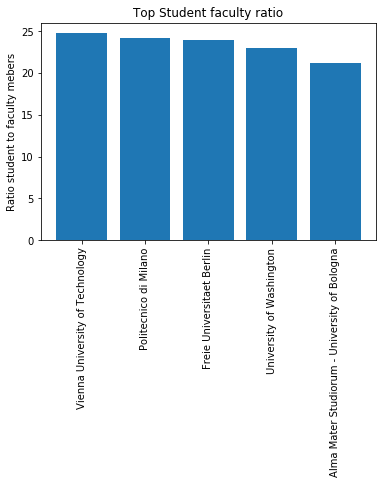

In [16]:
plotBarChart(tu_df.sort_values(by="ratio_students_fac",ascending=False).head()["title"],\
             tu_df.sort_values(by="ratio_students_fac",ascending=False).head()["ratio_students_fac"],\
             'Top Student faculty ratio', 'Ratio student to faculty mebers')

The `Vienna University of Technology` has the highest student to faculty members ratio. Most of the top 5 universities are in Europe.

In [17]:
tu_df.sort_values(by="ratio_inter",ascending=False).head()

,country,inter_faculties,inter_students,rank_display,region,title,total_faculties,total_students,ratio_students_fac,ratio_inter
34,United Kingdom,687.0,6748.0,35,Europe,London School of Economics and Political Scien...,1088.0,9760.0,8.970588,0.691393
11,Switzerland,1300.0,5896.0,12,Europe,Ecole Polytechnique Fédérale de Lausanne (EPFL),1695.0,10343.0,6.102065,0.570047
7,United Kingdom,2071.0,8746.0,8,Europe,Imperial College London,3930.0,16090.0,4.094148,0.543567
198,Netherlands,502.0,8234.0,200,Europe,Maastricht University,1277.0,16385.0,12.830854,0.502533
47,United States,425.0,6385.0,=47,North America,Carnegie Mellon University,1342.0,13356.0,9.952310,0.478062


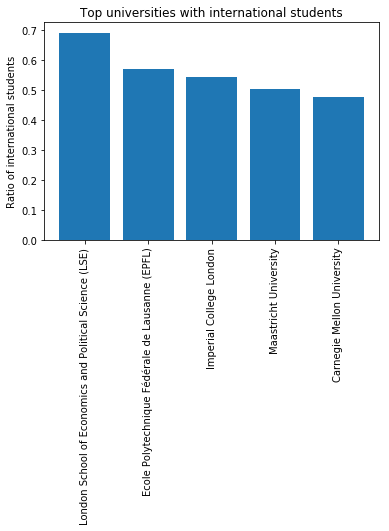

In [18]:
plotBarChart(tu_df.sort_values(by="ratio_inter",ascending=False).head()["title"],\
             tu_df.sort_values(by="ratio_inter",ascending=False).head()["ratio_inter"],\
             'Top universities with international students', 'Ratio of international students')

The `London School of Economics and Political Science` has the highest international student ratio. Most of the top 5 universities are in Europe.

- Answer the previous question aggregating the data by (c) country and (d) region.

In [19]:
tu_df.sort_values(["country","ratio_students_fac"],ascending=False).groupby("country").head(1)

,country,inter_faculties,inter_students,rank_display,region,title,total_faculties,total_students,ratio_students_fac,ratio_inter
60,United States,550.0,8373.0,61,North America,University of Washington,2484.0,56973.0,22.935990,0.146964
159,United Kingdom,440.0,4213.0,160,Europe,University of Bath,1165.0,14370.0,12.334764,0.293180
161,Taiwan,119.0,1187.0,=161,Asia,National Tsing Hua University,1020.0,13890.0,13.617647,0.085457
148,Switzerland,684.0,3441.0,=149,Europe,University of Basel,1057.0,12852.0,12.158940,0.267740
194,Sweden,646.0,2636.0,=195,Europe,Stockholm University,2154.0,28281.0,13.129526,0.093207
195,Spain,230.0,3848.0,=195,Europe,Universitat Autònoma de Barcelona,2187.0,31986.0,14.625514,0.120303
40,South Korea,147.0,584.0,=41,Asia,KAIST - Korea Advanced Institute of Science & ...,1250.0,9826.0,7.860800,0.059434
190,South Africa,379.0,3325.0,191,Africa,University of Cape Town,1733.0,19593.0,11.305828,0.169703
14,Singapore,3086.0,8917.0,15,Asia,National University of Singapore (NUS),5106.0,32728.0,6.409714,0.272458
172,Saudi Arabia,665.0,989.0,=173,Asia,King Fahd University of Petroleum & Minerals,1062.0,6040.0,5.687382,0.163742


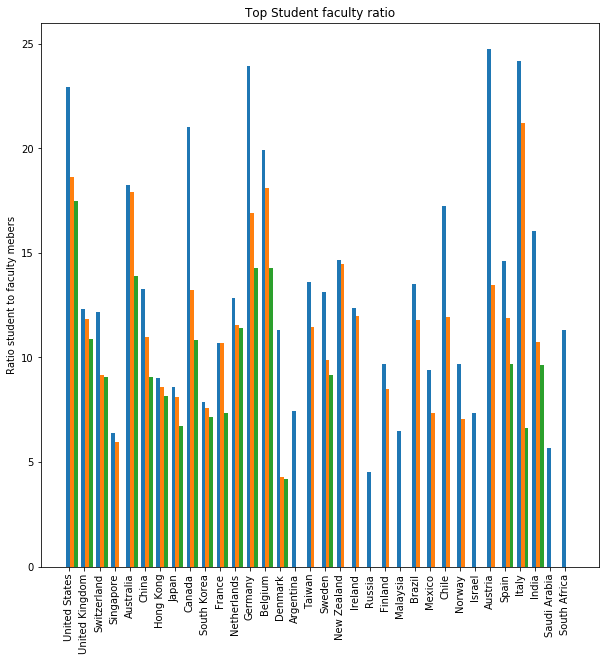

In [20]:
plotBarChartGroup(tu_df, "country", "ratio_students_fac", 'Top Student faculty ratio', 'Ratio student to faculty mebers')

The US, Germany, Austria and Italy have the universities with the highest student to faculty ratio.

In [21]:
tu_df.sort_values(["region","ratio_students_fac"],ascending=False).groupby("region").head(2)

,country,inter_faculties,inter_students,rank_display,region,title,total_faculties,total_students,ratio_students_fac,ratio_inter
175,Australia,546.0,7769.0,176,Oceania,University of Technology Sydney,1328.0,24207.0,18.228163,0.320940
59,Australia,1679.0,20578.0,60,Oceania,Monash University,3204.0,57433.0,17.925406,0.358296
60,United States,550.0,8373.0,61,North America,University of Washington,2484.0,56973.0,22.935990,0.146964
151,Canada,473.0,8962.0,152,North America,University of Waterloo,1689.0,35541.0,21.042629,0.252159
199,Chile,127.0,2134.0,201,Latin America,Universidad de Chile,2256.0,38848.0,17.219858,0.054932
182,Brazil,109.0,966.0,=182,Latin America,Universidade Estadual de Campinas (Unicamp),1968.0,26572.0,13.502033,0.036354
184,Austria,172.0,5199.0,=182,Europe,Vienna University of Technology,706.0,17479.0,24.757790,0.297443
169,Italy,231.0,5593.0,170,Europe,Politecnico di Milano,1500.0,36277.0,24.184667,0.154175
171,India,4.0,80.0,172,Asia,Indian Institute of Technology Delhi (IITD),466.0,7477.0,16.045064,0.010699
161,Taiwan,119.0,1187.0,=161,Asia,National Tsing Hua University,1020.0,13890.0,13.617647,0.085457


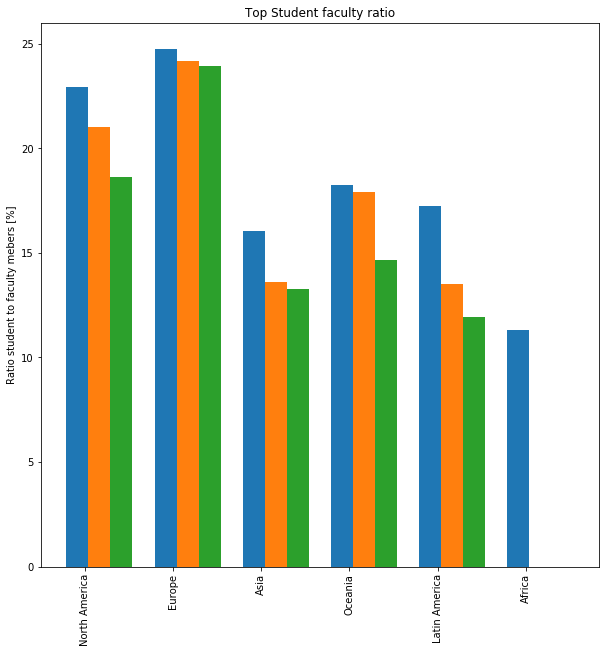

In [22]:
plotBarChartGroup(tu_df, "region", "ratio_students_fac", 'Top Student faculty ratio', 'Ratio student to faculty mebers [%]')

The North America and Europe have the universities with the highest student to faculty ratio.

In [23]:
tu_df.sort_values(["country","ratio_inter"],ascending=False).groupby("country").head(1)

,country,inter_faculties,inter_students,rank_display,region,title,total_faculties,total_students,ratio_students_fac,ratio_inter
47,United States,425.0,6385.0,=47,North America,Carnegie Mellon University,1342.0,13356.0,9.952310,0.478062
34,United Kingdom,687.0,6748.0,35,Europe,London School of Economics and Political Scien...,1088.0,9760.0,8.970588,0.691393
76,Taiwan,220.0,3152.0,=76,Asia,National Taiwan University (NTU),2807.0,32195.0,11.469540,0.097903
11,Switzerland,1300.0,5896.0,12,Europe,Ecole Polytechnique Fédérale de Lausanne (EPFL),1695.0,10343.0,6.102065,0.570047
78,Sweden,1002.0,6408.0,=78,Europe,Lund University,3031.0,27786.0,9.167272,0.230620
155,Spain,108.0,6134.0,156,Europe,Universitat de Barcelona,3863.0,46002.0,11.908361,0.133342
154,South Korea,364.0,3397.0,155,Asia,Hanyang University,3085.0,23348.0,7.568233,0.145494
190,South Africa,379.0,3325.0,191,Africa,University of Cape Town,1733.0,19593.0,11.305828,0.169703
10,Singapore,2993.0,7251.0,11,Asia,"Nanyang Technological University, Singapore (NTU)",4338.0,25738.0,5.933149,0.281724
172,Saudi Arabia,665.0,989.0,=173,Asia,King Fahd University of Petroleum & Minerals,1062.0,6040.0,5.687382,0.163742


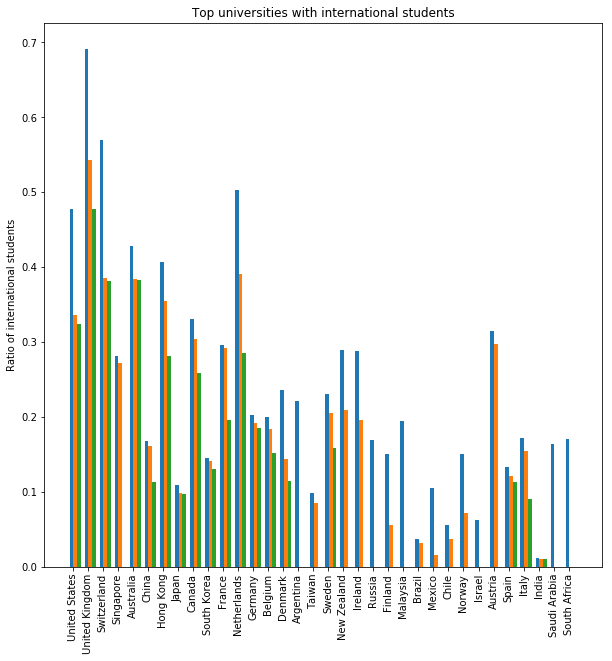

In [24]:
plotBarChartGroup(tu_df, "country", "ratio_inter", 'Top universities with international students', 'Ratio of international students')

The US, UK, Switzerland and Netherlands have the universities with the highest international student ratio.

In [25]:
tu_df.sort_values(["region","ratio_inter"],ascending=False).groupby("region").head(2)

,country,inter_faculties,inter_students,rank_display,region,title,total_faculties,total_students,ratio_students_fac,ratio_inter
41,Australia,1477.0,18030.0,=41,Oceania,The University of Melbourne,3311.0,42182.0,12.739958,0.427434
19,Australia,927.0,5551.0,20,Oceania,The Australian National University,1600.0,14442.0,9.026250,0.384365
47,United States,425.0,6385.0,=47,North America,Carnegie Mellon University,1342.0,13356.0,9.952310,0.478062
0,United States,1679.0,3717.0,1,North America,Massachusetts Institute of Technology (MIT),2982.0,11067.0,3.711268,0.335863
74,Argentina,3165.0,27109.0,75,Latin America,Universidad de Buenos Aires (UBA),16421.0,122301.0,7.447841,0.221658
197,Mexico,821.0,1412.0,199,Latin America,Instituto Tecnológico y de Estudios Superiores...,1822.0,13376.0,7.341383,0.105562
34,United Kingdom,687.0,6748.0,35,Europe,London School of Economics and Political Scien...,1088.0,9760.0,8.970588,0.691393
11,Switzerland,1300.0,5896.0,12,Europe,Ecole Polytechnique Fédérale de Lausanne (EPFL),1695.0,10343.0,6.102065,0.570047
25,Hong Kong,2085.0,8230.0,26,Asia,The University of Hong Kong,3012.0,20214.0,6.711155,0.407144
48,Hong Kong,1027.0,3273.0,49,Asia,City University of Hong Kong,1349.0,9240.0,6.849518,0.354221


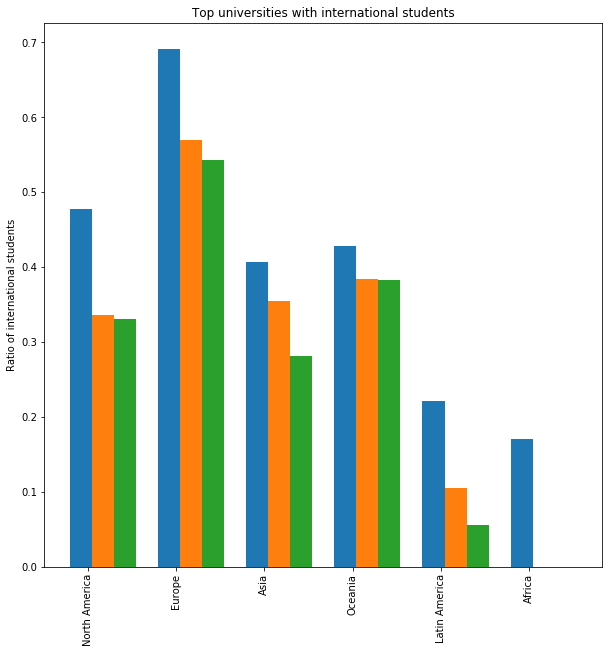

In [26]:
plotBarChartGroup(tu_df, "region", "ratio_inter", 'Top universities with international students', 'Ratio of international students')

Europe has the universities with the highest international student ratio.

TODO bar charts and explanation

# Obtain the 200 top-ranking universities in www.timeshighereducation.com (ranking 2018)

When loading the page http://timeshighereducation.com/world-university-rankings/2018/world-ranking, one can notice, that several additional requests are sent to the server. <br>
One of these files is a json file, which contains the complete ranking:
https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json. <br>
Luckily this ranking already contains all neccessary information.

In [27]:
th_link = "https://www.timeshighereducation.com" 

In [28]:
req_th_ranking = requests.get(th_link+'/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json')
th_ranking = req_th_ranking.json()["data"]
#th_ranking

In [29]:
len(th_ranking)

1102

In [30]:
# check format and equal ranks
print (th_ranking[2])
print (th_ranking[3])

# equal scores

{'rank_order': '30', 'rank': '=3', 'name': 'California Institute of Technology', 'scores_overall': '93.0', 'scores_overall_rank': '30', 'scores_teaching': '90.3', 'scores_teaching_rank': '1', 'scores_research': '97.5', 'scores_research_rank': '4', 'scores_citations': '99.5', 'scores_citations_rank': '10', 'scores_industry_income': '92.6', 'scores_industry_income_rank': '51', 'scores_international_outlook': '59.7', 'scores_international_outlook_rank': '322', 'record_type': 'private', 'member_level': '0', 'url': '/world-university-rankings/california-institute-technology', 'nid': 128779, 'location': 'United States', 'stats_number_students': '2,209', 'stats_student_staff_ratio': '6.5', 'stats_pc_intl_students': '27%', 'stats_female_male_ratio': '31 : 69', 'aliases': 'California Institute of Technology caltech', 'subjects_offered': 'Architecture,Biological Sciences,Business & Management,Chemical Engineering,Chemistry,Computer Science,Economics & Econometrics,Electrical & Electronic Enginee

In [31]:
th_ranking_200 = th_ranking[:n]

In [32]:
th_relevant_values = ["name", "aliases", "location", "rank", "stats_number_students", "stats_student_staff_ratio", "stats_pc_intl_students"]

th_ranking_filtered = []
for i in range(n):
    tmp_dict = {}
    for s in th_relevant_values:
        tmp_dict[s] = th_ranking_200[i][s]
    th_ranking_filtered.append(tmp_dict)

In [33]:
th_df = pd.DataFrame.from_dict(th_ranking_filtered)
th_df.head()

,aliases,location,name,rank,stats_number_students,stats_pc_intl_students,stats_student_staff_ratio
0,University of Oxford,United Kingdom,University of Oxford,1,"20,409",38%,11.2
1,University of Cambridge,United Kingdom,University of Cambridge,2,"18,389",35%,10.9
2,California Institute of Technology caltech,United States,California Institute of Technology,=3,"2,209",27%,6.5
3,Stanford University,United States,Stanford University,=3,"15,845",22%,7.5
4,Massachusetts Institute of Technology,United States,Massachusetts Institute of Technology,5,"11,177",34%,8.7


## Statistics on second ranking

In [34]:
# transform to numerical values
th_df.stats_number_students = th_df.stats_number_students.apply(lambda x: ToNumeric(x))
tu_df.stats_number_students = th_df.stats_number_students.apply(pd.to_numeric)

th_df.stats_pc_intl_students = th_df.stats_pc_intl_students.apply(lambda x: ToNumeric(x))
th_df.stats_pc_intl_students = th_df.stats_pc_intl_students.apply(pd.to_numeric)

th_df.stats_student_staff_ratio = th_df.stats_student_staff_ratio.apply(lambda x: ToNumeric(x))
th_df.stats_student_staff_ratio = th_df.stats_student_staff_ratio.apply(pd.to_numeric)

Which are the best universities in term of: (a) ratio between faculty members and students, (b) ratio of international students?

In [35]:
th_df.sort_values(by="stats_student_staff_ratio",ascending=False).head()

,aliases,location,name,rank,stats_number_students,stats_pc_intl_students,stats_student_staff_ratio
99,University of Bonn,Germany,University of Bonn,=100,35619,0.13,77.9
124,University of Mannheim,Germany,University of Mannheim,125,10995,0.16,74.5
91,Technical University of Berlin,Germany,Technical University of Berlin,92,22390,0.20,64.3
163,University of Erlangen-Nuremberg,Germany,University of Erlangen-Nuremberg,=162,38730,0.12,58.5
78,RWTH Aachen University,Germany,RWTH Aachen University,79,43721,0.18,57.7


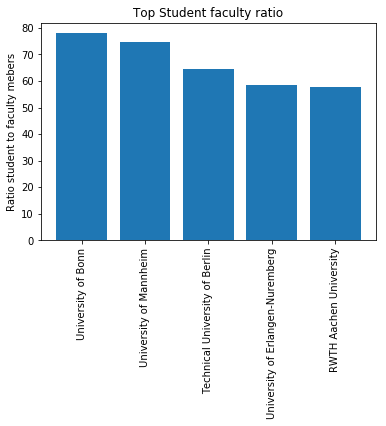

In [36]:
plotBarChart(th_df.sort_values(by="stats_student_staff_ratio",ascending=False).head()["name"],\
             th_df.sort_values(by="stats_student_staff_ratio",ascending=False).head()["stats_student_staff_ratio"],\
             'Top Student faculty ratio', 'Ratio student to faculty mebers')

The `University of Bonn` has the highest student to faculty members ratio. All top 5 universities are in Germany.

In [37]:
th_df.sort_values(by="stats_pc_intl_students",ascending=False).head()

,aliases,location,name,rank,stats_number_students,stats_pc_intl_students,stats_student_staff_ratio
24,London School of Economics and Political Science,United Kingdom,London School of Economics and Political Science,=25,10065,0.71,12.2
178,University of Luxembourg,Luxembourg,University of Luxembourg,=179,4969,0.57,14.6
37,École Polytechnique Fédérale de Lausanne,Switzerland,École Polytechnique Fédérale de Lausanne,=38,9928,0.55,11.2
7,Imperial College London,United Kingdom,Imperial College London,8,15857,0.55,11.4
102,Maastricht University,Netherlands,Maastricht University,103,16727,0.50,18.0


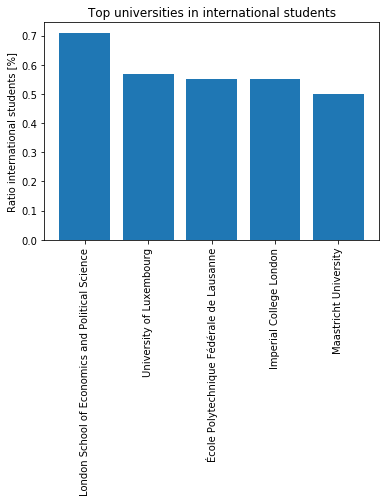

In [38]:
plotBarChart(th_df.sort_values(by="stats_pc_intl_students",ascending=False).head()["name"],\
             th_df.sort_values(by="stats_pc_intl_students",ascending=False).head()["stats_pc_intl_students"],\
             'Top universities in international students', 'Ratio international students [%]')

The `London School of Economics and Political Science` has the highest international student ratio. All of the top 5 universities are in Europe.

Answer the previous question aggregating the data by (c) country and (d) region.

In [39]:
th_df.sort_values(["location","stats_student_staff_ratio"],ascending=False).groupby("location").head(1)

,aliases,location,name,rank,stats_number_students,stats_pc_intl_students,stats_student_staff_ratio
52,"University of California, Santa Barbara",United States,"University of California, Santa Barbara",53,23054,0.14,28.1
129,University of Exeter,United Kingdom,University of Exeter,=130,19159,0.28,17.5
199,National Taiwan University,Taiwan,National Taiwan University,=198,31758,0.08,11.5
94,University of Basel,Switzerland,University of Basel,=95,12729,0.27,17.7
134,Stockholm University,Sweden,Stockholm University,=134,33156,0.08,24.9
139,Pompeu Fabra University,Spain,Pompeu Fabra University,140,11172,0.12,20.8
110,Sungkyunkwan University (SKKU),South Korea,Sungkyunkwan University (SKKU),=111,24055,0.12,19.6
170,University of Cape Town,South Africa,University of Cape Town,171,20775,0.18,11.7
21,National University of Singapore nus,Singapore,National University of Singapore,=22,30602,0.30,17.0
193,Lomonosov Moscow State University,Russian Federation,Lomonosov Moscow State University,194,29236,0.22,7.3


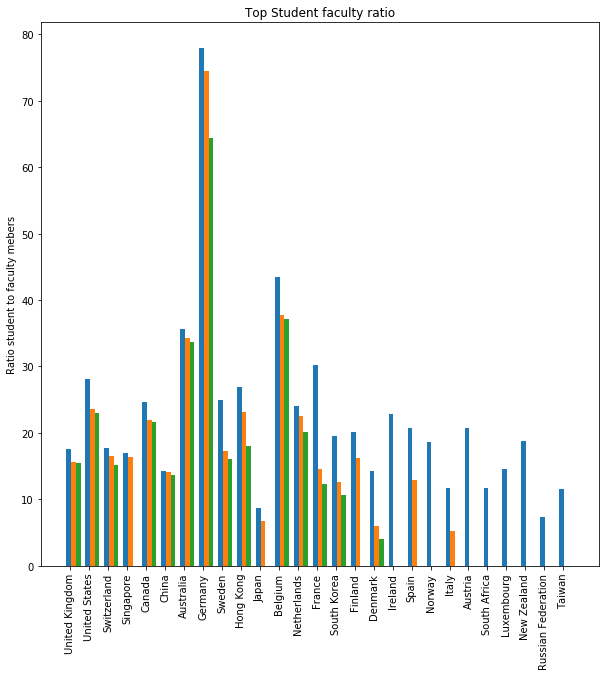

In [40]:
plotBarChartGroup(th_df, "location", "stats_student_staff_ratio", 'Top Student faculty ratio', 'Ratio student to faculty mebers')

Germany has by far the highest student to faculty members ratio.

In [41]:
th_df.sort_values(["location","stats_pc_intl_students"],ascending=False).groupby("location").head(1)

,aliases,location,name,rank,stats_number_students,stats_pc_intl_students,stats_student_staff_ratio
23,Carnegie Mellon University,United States,Carnegie Mellon University,24,12676,0.45,13.5
24,London School of Economics and Political Science,United Kingdom,London School of Economics and Political Science,=25,10065,0.71,12.2
199,National Taiwan University,Taiwan,National Taiwan University,=198,31758,0.08,11.5
37,École Polytechnique Fédérale de Lausanne,Switzerland,École Polytechnique Fédérale de Lausanne,=38,9928,0.55,11.2
38,Karolinska Institute,Sweden,Karolinska Institute,=38,7424,0.19,10.9
146,Autonomous University of Barcelona,Spain,Autonomous University of Barcelona,=147,32309,0.16,12.9
110,Sungkyunkwan University (SKKU),South Korea,Sungkyunkwan University (SKKU),=111,24055,0.12,19.6
170,University of Cape Town,South Africa,University of Cape Town,171,20775,0.18,11.7
51,"Nanyang Technological University, Singapore N...",Singapore,"Nanyang Technological University, Singapore",52,25499,0.31,16.3
193,Lomonosov Moscow State University,Russian Federation,Lomonosov Moscow State University,194,29236,0.22,7.3


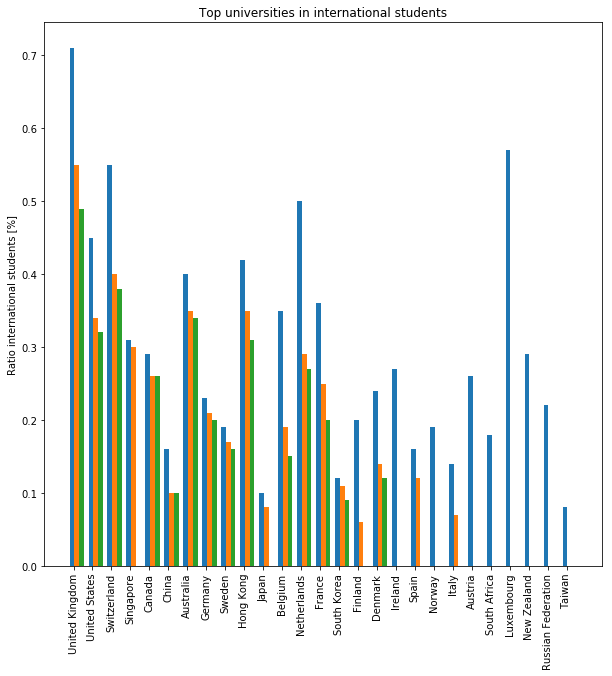

In [42]:
plotBarChartGroup(th_df, "location", "stats_pc_intl_students", 'Top universities in international students', 'Ratio international students [%]')

The UK, Switzerland, Netherlands and Luxembourg have the higest international student ratio.

Unfortunately the second ranking does not contain the region column. We can obtain it from the first ranking

In [43]:
region_map = {}
for country in th_df["location"].values:
    if country in tu_df["country"].values:
        region_map[country] = tu_df[tu_df.country == country]["region"].iloc[0]
    else:        
        if country == 'Russian Federation':
            region_map[country] = tu_df[tu_df.country == "Russia"]["region"].iloc[0]
        elif country == 'Luxembourg':
            region_map[country] = "Europe"
        else:
            print (country)
        
th_df['region'] = th_df.apply(lambda x: region_map[x['location']], axis=1)

In [44]:
th_df.sort_values(["region","stats_student_staff_ratio"],ascending=False).groupby("region").head(2)

,aliases,location,name,rank,stats_number_students,stats_pc_intl_students,stats_student_staff_ratio,region
64,University of Queensland,Australia,University of Queensland,65,38968,0.26,35.7,Oceania
133,University of Adelaide,Australia,University of Adelaide,=134,21241,0.26,34.3,Oceania
52,"University of California, Santa Barbara",United States,"University of California, Santa Barbara",53,23054,0.14,28.1,North America
77,McMaster University,Canada,McMaster University,78,23693,0.15,24.7,North America
99,University of Bonn,Germany,University of Bonn,=100,35619,0.13,77.9,Europe
124,University of Mannheim,Germany,University of Mannheim,125,10995,0.16,74.5,Europe
182,Hong Kong Polytechnic University hkpu hong kon...,Hong Kong,Hong Kong Polytechnic University,=182,21773,0.25,26.9,Asia
43,Hong Kong University of Science and Technology...,Hong Kong,Hong Kong University of Science and Technology,44,10214,0.31,23.1,Asia
170,University of Cape Town,South Africa,University of Cape Town,171,20775,0.18,11.7,Africa


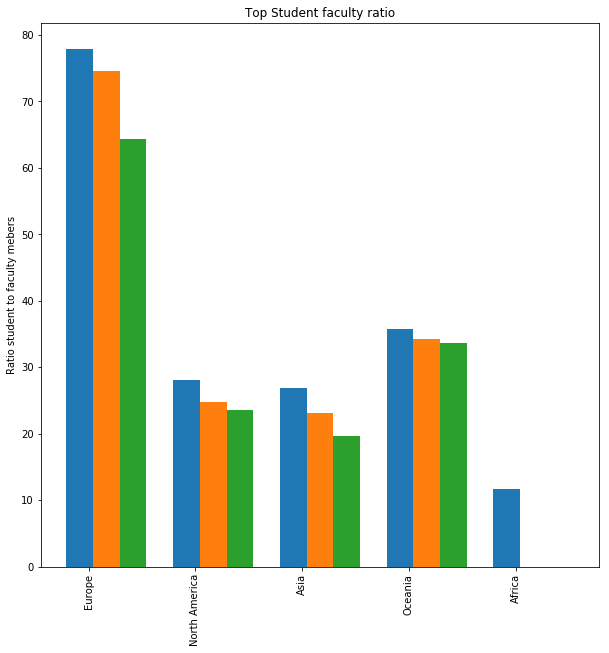

In [45]:
plotBarChartGroup(th_df, "region", "stats_student_staff_ratio", 'Top Student faculty ratio', 'Ratio student to faculty mebers')


Europe has by far the highest students to staff ratio

In [46]:
th_df.sort_values(["region","stats_pc_intl_students"],ascending=False).groupby("region").head(2)

,aliases,location,name,rank,stats_number_students,stats_pc_intl_students,stats_student_staff_ratio,region
31,University of Melbourne,Australia,University of Melbourne,32,42116,0.40,26.6,Oceania
47,Australian National University anu,Australia,Australian National University,48,15986,0.35,19.3,Oceania
23,Carnegie Mellon University,United States,Carnegie Mellon University,24,12676,0.45,13.5,North America
4,Massachusetts Institute of Technology,United States,Massachusetts Institute of Technology,5,11177,0.34,8.7,North America
24,London School of Economics and Political Science,United Kingdom,London School of Economics and Political Science,=25,10065,0.71,12.2,Europe
178,University of Luxembourg,Luxembourg,University of Luxembourg,=179,4969,0.57,14.6,Europe
39,University of Hong Kong HKU hku The University...,Hong Kong,University of Hong Kong,40,18364,0.42,18.0,Asia
119,City University of Hong Kong CityU HK City U H...,Hong Kong,City University of Hong Kong,=119,9240,0.35,11.2,Asia
170,University of Cape Town,South Africa,University of Cape Town,171,20775,0.18,11.7,Africa


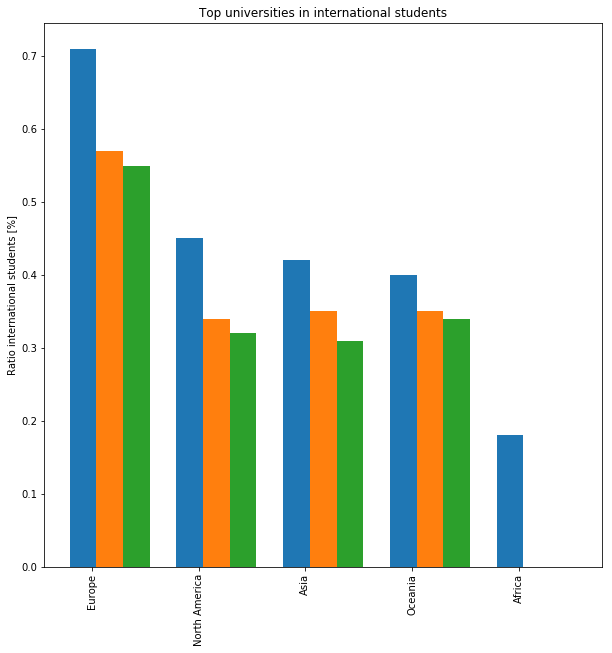

In [47]:
plotBarChartGroup(th_df, "region", "stats_pc_intl_students", 'Top universities in international students', 'Ratio international students [%]')


Europe has by far the most international students.

# Merge Rankings

The idea is to modify the name of each university to make them as equal as possible:
 - Lower all letters
 - Translating important words (university, school, technical..)
 - Get rid of special characters
 - Get rid of prepositions
 - Get rid of parenthesis and their content. Example: (UCB)


In [48]:
df_top_tomerge = tu_df.copy()
df_times_tomerge = th_df.copy()

In [49]:
def modify_tomerge(string):
    
    #lower case
    string = string.str.lower()
    
    # University
    string = string.str.replace('universite','university')
    string = string.str.replace('universitat','university')
    string = string.str.replace('universitaet','university')
    string = string.str.replace('universidad','university')
    string = string.str.replace('universiteit','university')
    string = string.str.replace('universidade','university')
    string = string.str.replace('universitari','university')


    # school
    string = string.replace('scuola','school')
    
    #technical
    string = string.replace('technische','technical')
    
    #studies
    string = string.replace('studi','studies')
    string = string.replace('estudios','studies')


    #some translations
    string = string.replace('freie','free')
    string = string.replace('tecnológico','technological')



    #special characters
    string = string.str.replace('é','e')
    string = string.str.replace('-','')
    string = string.str.replace('ä','ae')
    string = string.str.replace('ã','a')
    string = string.str.replace('ó','o')
    string = string.str.replace('ö','o')
    string = string.str.replace('&','')
    string = string.str.replace('/','')


    #prepositions
    string = string.str.replace('of','')
    string = string.str.replace('the','')
    string = string.str.replace('at','')
    string = string.str.replace('de','')
    string = string.str.replace('y','')
    string = string.str.replace('di ','')
    string = string.str.replace(',','')


    #parenthesis and their content
    string = string.str.replace(r"\(.*\)","")
    
    #space
    string = string.str.replace(' ','')
    

    return string
   

In [50]:
df_top_tomerge = df_top_tomerge.rename(columns={'title': 'name', 'rank_display':'rank_top'})
df_times_tomerge = df_times_tomerge.rename(columns={'rank': 'rank_times'})

df_times_tomerge['name'] = modify_tomerge(df_times_tomerge['name'])
df_top_tomerge['name'] = modify_tomerge(df_top_tomerge['name'])

df = df_top_tomerge.merge(df_times_tomerge, how='inner')

df.head()

,country,inter_faculties,inter_students,rank_top,region,name,total_faculties,total_students,ratio_students_fac,ratio_inter,aliases,location,rank_times,stats_number_students,stats_pc_intl_students,stats_student_staff_ratio
0,United States,1679.0,3717.0,1,North America,massachusettsinstitutetechnolog,2982.0,11067.0,3.711268,0.335863,Massachusetts Institute of Technology,United States,5,11177,0.34,8.7
1,United States,2042.0,3611.0,2,North America,stanforduniversit,4285.0,15878.0,3.705484,0.227422,Stanford University,United States,=3,15845,0.22,7.5
2,United States,1311.0,5266.0,3,North America,harvarduniversit,4350.0,22429.0,5.156092,0.234785,Harvard University,United States,6,20326,0.26,8.9
3,United States,350.0,647.0,4,North America,californiainstitutetechnolog,953.0,2255.0,2.366212,0.286918,California Institute of Technology caltech,United States,=3,2209,0.27,6.5
4,United Kingdom,2278.0,6699.0,5,Europe,universitcambridge,5490.0,18770.0,3.418944,0.356899,University of Cambridge,United Kingdom,2,18389,0.35,10.9


In [51]:
def RankToNumeric(x):
    if(type(x) is not float and type(x) is not int):
        x = x.replace('=','')
    return x

We put all the ranking in Integer (mostly to have the equality in int as they were simbolized as "=ranking")

In [52]:
df.rank_times = df.rank_times.apply(lambda x: RankToNumeric(x))
df.rank_times = df.rank_times.apply(pd.to_numeric)
df.rank_top = df.rank_top.apply(lambda x: RankToNumeric(x))
df.rank_top = df.rank_top.apply(pd.to_numeric)

# Exploratory Data Analysis

In [53]:
df

,country,inter_faculties,inter_students,rank_top,region,name,total_faculties,total_students,ratio_students_fac,ratio_inter,aliases,location,rank_times,stats_number_students,stats_pc_intl_students,stats_student_staff_ratio
0,United States,1679.0,3717.0,1,North America,massachusettsinstitutetechnolog,2982.0,11067.0,3.711268,0.335863,Massachusetts Institute of Technology,United States,5,11177,0.34,8.7
1,United States,2042.0,3611.0,2,North America,stanforduniversit,4285.0,15878.0,3.705484,0.227422,Stanford University,United States,3,15845,0.22,7.5
2,United States,1311.0,5266.0,3,North America,harvarduniversit,4350.0,22429.0,5.156092,0.234785,Harvard University,United States,6,20326,0.26,8.9
3,United States,350.0,647.0,4,North America,californiainstitutetechnolog,953.0,2255.0,2.366212,0.286918,California Institute of Technology caltech,United States,3,2209,0.27,6.5
4,United Kingdom,2278.0,6699.0,5,Europe,universitcambridge,5490.0,18770.0,3.418944,0.356899,University of Cambridge,United Kingdom,2,18389,0.35,10.9
5,United Kingdom,2964.0,7353.0,6,Europe,universitoxford,6750.0,19720.0,2.921481,0.372870,University of Oxford,United Kingdom,1,20409,0.38,11.2
6,United Kingdom,2071.0,8746.0,8,Europe,imperialcollegelondon,3930.0,16090.0,4.094148,0.543567,Imperial College London,United Kingdom,8,15857,0.55,11.4
7,United States,635.0,3379.0,9,North America,universitchicago,2449.0,13557.0,5.535729,0.249244,University of Chicago,United States,9,13525,0.25,6.2
8,Singapore,2993.0,7251.0,11,Asia,nanangtechnologicaluniversitsingapore,4338.0,25738.0,5.933149,0.281724,"Nanyang Technological University, Singapore N...",Singapore,52,25499,0.31,16.3
9,Switzerland,1300.0,5896.0,12,Europe,ecolepoltechniqueferalelausanne,1695.0,10343.0,6.102065,0.570047,École Polytechnique Fédérale de Lausanne,Switzerland,38,9928,0.55,11.2


In [54]:
#There is one value NaN that we drop
df = df.dropna(axis=0)

In [55]:
# set column country, location and region to categorial
df["country"] = df["country"].astype('category')
df["location"] = df["location"].astype('category')
df["region"] = df["region"].astype('category')

C:\Users\M4X\AppData\Local\conda\conda\envs\ada\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\M4X\AppData\Local\conda\conda\envs\ada\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\M4X\AppData\Local\conda\conda\envs\ada\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

In [56]:
df.describe()

,inter_faculties,inter_students,rank_top,total_faculties,total_students,ratio_students_fac,ratio_inter,rank_times,stats_pc_intl_students,stats_student_staff_ratio
count,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000
mean,902.921429,5595.278571,86.707143,3012.464286,25662.771429,9.138490,0.231805,87.400000,0.228929,15.516429
std,671.404874,3719.500075,55.028900,1596.041855,13389.056345,3.813895,0.116226,55.190683,0.117404,8.537118
min,1.000000,48.000000,1.000000,86.000000,532.000000,2.366212,0.034182,1.000000,0.030000,4.100000
25%,469.250000,3104.000000,38.000000,1813.750000,16023.750000,6.626203,0.149010,41.750000,0.137500,10.700000
50%,694.000000,4792.500000,82.000000,2846.000000,24290.500000,8.636562,0.226005,81.500000,0.225000,13.850000
75%,1155.750000,7445.750000,134.250000,3862.250000,32553.250000,11.310330,0.289568,132.500000,0.290000,18.025000
max,3905.000000,21910.000000,200.000000,9581.000000,72207.000000,22.935990,0.691393,198.000000,0.710000,57.700000


In [57]:
df_corr = df.corr()
df_corr

,inter_faculties,inter_students,rank_top,total_faculties,total_students,ratio_students_fac,ratio_inter,rank_times,stats_pc_intl_students,stats_student_staff_ratio
inter_faculties,1.000000,0.547842,-0.486923,0.627221,0.284175,-0.283921,0.329318,-0.334485,0.272406,0.016783
inter_students,0.547842,1.000000,-0.223353,0.378067,0.630817,0.324558,0.500900,-0.229434,0.376799,0.344671
rank_top,-0.486923,-0.223353,1.000000,-0.350515,-0.014428,0.336521,-0.282113,0.695884,-0.270353,0.207583
total_faculties,0.627221,0.378067,-0.350515,1.000000,0.593841,-0.308853,-0.148746,-0.348804,-0.195652,-0.073493
total_students,0.284175,0.630817,-0.014428,0.593841,1.000000,0.509092,-0.228786,-0.146249,-0.310630,0.380978
ratio_students_fac,-0.283921,0.324558,0.336521,-0.308853,0.509092,1.000000,-0.084413,0.153570,-0.114505,0.562536
ratio_inter,0.329318,0.500900,-0.282113,-0.148746,-0.228786,-0.084413,1.000000,-0.191657,0.952397,0.016627
rank_times,-0.334485,-0.229434,0.695884,-0.348804,-0.146249,0.153570,-0.191657,1.000000,-0.165278,0.065461
stats_pc_intl_students,0.272406,0.376799,-0.270353,-0.195652,-0.310630,-0.114505,0.952397,-0.165278,1.000000,-0.020798
stats_student_staff_ratio,0.016783,0.344671,0.207583,-0.073493,0.380978,0.562536,0.016627,0.065461,-0.020798,1.000000


In [58]:
df_corr[["rank_top","rank_times"]]

,rank_top,rank_times
inter_faculties,-0.486923,-0.334485
inter_students,-0.223353,-0.229434
rank_top,1.000000,0.695884
total_faculties,-0.350515,-0.348804
total_students,-0.014428,-0.146249
ratio_students_fac,0.336521,0.153570
ratio_inter,-0.282113,-0.191657
rank_times,0.695884,1.000000
stats_pc_intl_students,-0.270353,-0.165278
stats_student_staff_ratio,0.207583,0.065461


The ranking of topuniversities.com is mostely good for a high number of international faculties.
The ranking of timeshighereducation.com is mostely good for a combination of high number of international faculties and students.

In [59]:
for i in range(df.columns.shape[0]):
    for j in range(df.columns.shape[0]):
        if i<j and df.dtypes[i] == "float" and df.dtypes[j] == "float":
            if np.abs(df_corr.loc[df.columns[i],df.columns[j]]) > 0.5:
                print ("Columns {} and {} have a high corr coeff of {}".format(df.columns[i], df.columns[j], df_corr.loc[df.columns[i],df.columns[j]]))

Columns inter_faculties and inter_students have a high corr coeff of 0.5478418451236599
Columns inter_faculties and total_faculties have a high corr coeff of 0.6272211760886162
Columns inter_students and total_students have a high corr coeff of 0.6308170769125706
Columns inter_students and ratio_inter have a high corr coeff of 0.500900308005819
Columns total_faculties and total_students have a high corr coeff of 0.5938408345501245
Columns total_students and ratio_students_fac have a high corr coeff of 0.5090918691847359
Columns ratio_students_fac and stats_student_staff_ratio have a high corr coeff of 0.5625364726514626
Columns ratio_inter and stats_pc_intl_students have a high corr coeff of 0.9523969440563875


It stands out, that only the ratio of international students between the both ranking does correlate strongly.
Therefore, let's have a look at the differences

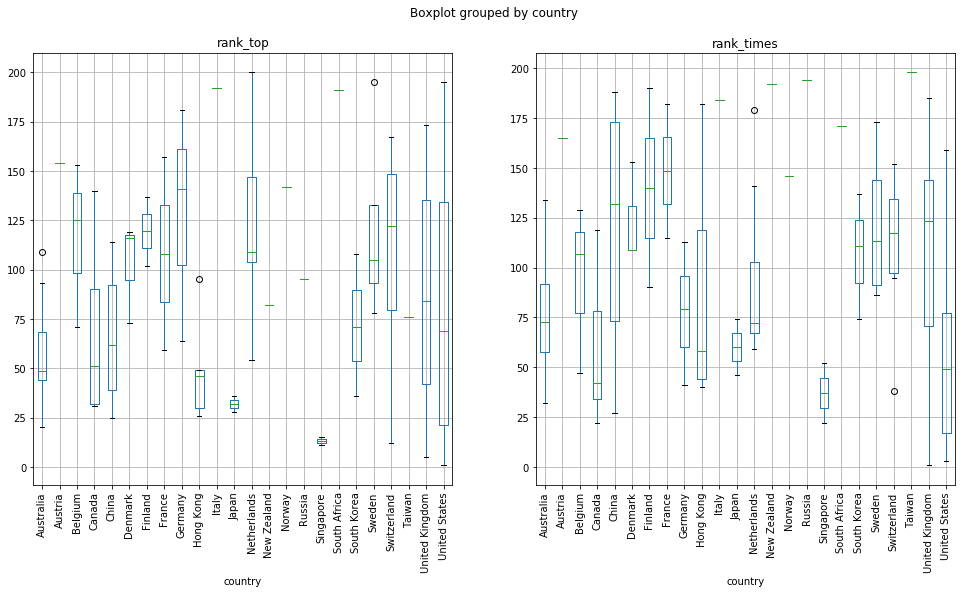

In [60]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize= (16,8))
df.boxplot(column="rank_top",
                 by= "country",
                 rot=90,
                 ax=axes[0])
df.boxplot(column="rank_times",
                 by= "country",
                 rot=90,
                 ax=axes[1])

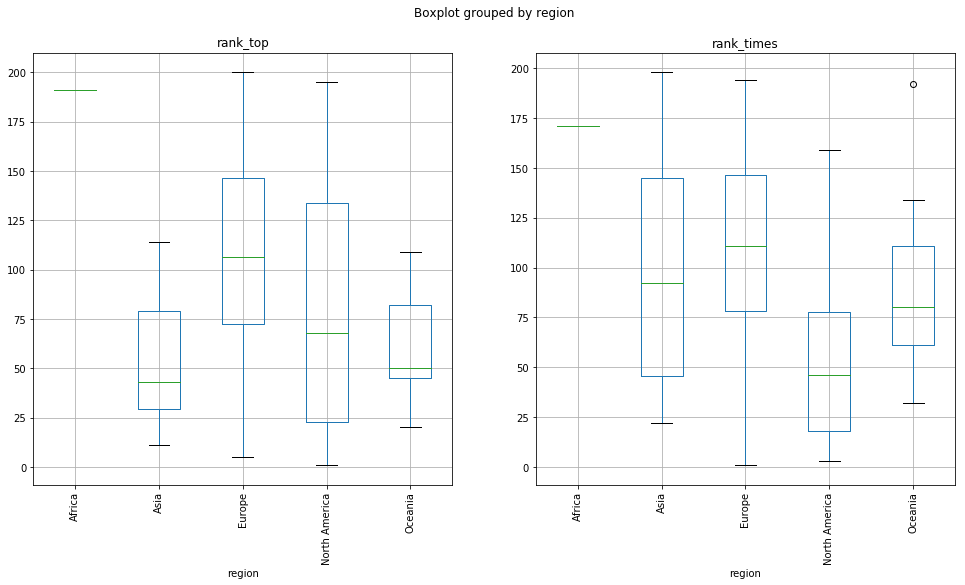

In [61]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize= (16,8))
df.boxplot(column="rank_top",
                 by= "region",
                 rot=90,
                 ax=axes[0])
df.boxplot(column="rank_times",
                 by= "region",
                 rot=90,
                 ax=axes[1])

The European universities get a similiar rating on both sites.
Topuniversities favors Asia over North America, timeshighereducation the other way around

In [62]:
# Find not matching student numbers
tu_stud = pd.DataFrame(tu_df.total_students)
th_stud = pd.DataFrame(th_df.stats_number_students).astype("float")
ratio = (tu_stud.total_students/th_stud.stats_number_students)
stud_deviation = pd.DataFrame(ratio,columns=["students_deviation"])
df_stud_deviation = df.join(stud_deviation)
df_stud_deviation.sort_values(["students_deviation"], ascending=False).head()

,country,inter_faculties,inter_students,rank_top,region,name,total_faculties,total_students,ratio_students_fac,ratio_inter,aliases,location,rank_times,stats_number_students,stats_pc_intl_students,stats_student_staff_ratio,students_deviation
114,Switzerland,1031.0,3337.0,146,Europe,universitlausanne,2173.0,13435.0,6.182697,0.248381,University of Lausanne,Switzerland,152,13065,0.25,13.6,11.609503
2,United States,1311.0,5266.0,3,North America,harvarduniversit,4350.0,22429.0,5.156092,0.234785,Harvard University,United States,6,20326,0.26,8.9,10.153463
136,South Africa,379.0,3325.0,191,Africa,universitcapetown,1733.0,19593.0,11.305828,0.169703,University of Cape Town,South Africa,171,20775,0.18,11.7,8.064675
121,France,91.0,221.0,157,Europe,ecolenormalesuperieurelon,382.0,2020.0,5.287958,0.109406,École Normale Supérieure de Lyon,France,182,2221,0.13,8.5,7.332317
85,Sweden,494.0,1937.0,98,Europe,kthroalinstitutetechnolog,1500.0,12658.0,8.438667,0.153026,KTH Royal Institute of Technology,Sweden,173,12951,0.17,16.0,6.700202


In [63]:
df_stud_deviation.sort_values(["students_deviation"], ascending=True).head()

,country,inter_faculties,inter_students,rank_top,region,name,total_faculties,total_students,ratio_students_fac,ratio_inter,aliases,location,rank_times,stats_number_students,stats_pc_intl_students,stats_student_staff_ratio,students_deviation
42,United States,425.0,6385.0,47,North America,carnegiemellonuniversit,1342.0,13356.0,9.952310,0.478062,Carnegie Mellon University,United States,24,12676,0.45,13.5,0.048948
70,New Zealand,645.0,8568.0,82,Oceania,universitauckland,2047.0,29641.0,14.480215,0.289059,University of Auckland,New Zealand,192,30348,0.29,18.8,0.058601
116,United States,484.0,2154.0,147,North America,emoruniversit,2560.0,12852.0,5.020313,0.167600,Emory University,United States,98,12649,0.19,4.4,0.132835
58,United States,108.0,4744.0,67,North America,universittexasaustin,2833.0,47995.0,16.941405,0.098844,University of Texas at Austin,United States,49,48561,0.10,17.1,0.133050
3,United States,350.0,647.0,4,North America,californiainstitutetechnolog,953.0,2255.0,2.366212,0.286918,California Institute of Technology caltech,United States,3,2209,0.27,6.5,0.142316


In [64]:
# Find not matching ranking positions
tu_ranks = pd.DataFrame(df.rank_top)
th_ranks = pd.DataFrame(df.rank_times)
ratio = np.abs(tu_ranks.rank_top-th_ranks.rank_times)
rank_deviation = pd.DataFrame(ratio,columns=["rank_deviation"])
df_rank_deviation = df.join(rank_deviation)
df_rank_deviation.sort_values(["rank_deviation"], ascending=False).head()

,country,inter_faculties,inter_students,rank_top,region,name,total_faculties,total_students,ratio_students_fac,ratio_inter,aliases,location,rank_times,stats_number_students,stats_pc_intl_students,stats_student_staff_ratio,rank_deviation
55,China,887.0,2858.0,62,Asia,shanghaijiaotonguniversit,3544.0,38931.0,10.985045,0.073412,Shanghai Jiao Tong University,China,188,37288,0.06,12.4,126
65,Taiwan,220.0,3152.0,76,Asia,nionaltaiwanuniversit,2807.0,32195.0,11.469540,0.097903,National Taiwan University,Taiwan,198,31758,0.08,11.5,122
70,New Zealand,645.0,8568.0,82,Oceania,universitauckland,2047.0,29641.0,14.480215,0.289059,University of Auckland,New Zealand,192,30348,0.29,18.8,110
125,United States,195.0,6542.0,163,North America,universitminnesota,4919.0,59742.0,12.145151,0.109504,University of Minnesota,United States,56,60949,0.11,17.4,107
81,Russia,373.0,5098.0,95,Europe,lomonosovmoscowsteuniversit,6709.0,30233.0,4.506335,0.168624,Lomonosov Moscow State University,Russian Federation,194,29236,0.22,7.3,99


In [65]:
df_rank_deviation.sort_values(["rank_deviation"], ascending=False).head()

,country,inter_faculties,inter_students,rank_top,region,name,total_faculties,total_students,ratio_students_fac,ratio_inter,aliases,location,rank_times,stats_number_students,stats_pc_intl_students,stats_student_staff_ratio,rank_deviation
55,China,887.0,2858.0,62,Asia,shanghaijiaotonguniversit,3544.0,38931.0,10.985045,0.073412,Shanghai Jiao Tong University,China,188,37288,0.06,12.4,126
65,Taiwan,220.0,3152.0,76,Asia,nionaltaiwanuniversit,2807.0,32195.0,11.469540,0.097903,National Taiwan University,Taiwan,198,31758,0.08,11.5,122
70,New Zealand,645.0,8568.0,82,Oceania,universitauckland,2047.0,29641.0,14.480215,0.289059,University of Auckland,New Zealand,192,30348,0.29,18.8,110
125,United States,195.0,6542.0,163,North America,universitminnesota,4919.0,59742.0,12.145151,0.109504,University of Minnesota,United States,56,60949,0.11,17.4,107
81,Russia,373.0,5098.0,95,Europe,lomonosovmoscowsteuniversit,6709.0,30233.0,4.506335,0.168624,Lomonosov Moscow State University,Russian Federation,194,29236,0.22,7.3,99


In [66]:
# Find not matching faculies
tu_facs = pd.DataFrame(tu_df.total_faculties)
th_students_facs = pd.DataFrame(th_df.stats_student_staff_ratio)
ratio = (tu_facs.total_faculties/(th_stud.stats_number_students/th_students_facs.stats_student_staff_ratio))
fac_deviation = pd.DataFrame(ratio,columns=["fac_deviation"])
df_fac_deviation = df.join(fac_deviation)
df_fac_deviation.sort_values(["fac_deviation"], ascending=False).head()

,country,inter_faculties,inter_students,rank_top,region,name,total_faculties,total_students,ratio_students_fac,ratio_inter,aliases,location,rank_times,stats_number_students,stats_pc_intl_students,stats_student_staff_ratio,fac_deviation
121,France,91.0,221.0,157,Europe,ecolenormalesuperieurelon,382.0,2020.0,5.287958,0.109406,École Normale Supérieure de Lyon,France,182,2221,0.13,8.5,14.872110
2,United States,1311.0,5266.0,3,North America,harvarduniversit,4350.0,22429.0,5.156092,0.234785,Harvard University,United States,6,20326,0.26,8.9,12.799909
136,South Africa,379.0,3325.0,191,Africa,universitcapetown,1733.0,19593.0,11.305828,0.169703,University of Cape Town,South Africa,171,20775,0.18,11.7,9.406435
63,Denmark,2336.0,3683.0,73,Europe,universitcopenhagen,7483.0,32119.0,4.292262,0.114667,University of Copenhagen,Denmark,109,30395,0.14,4.1,9.349748
94,Australia,633.0,8114.0,109,Oceania,universitalai,1729.0,21240.0,12.284558,0.382015,University of Adelaide,Australia,134,21241,0.26,34.3,9.329036


In [67]:
df_fac_deviation.sort_values(["fac_deviation"], ascending=True).head()


,country,inter_faculties,inter_students,rank_top,region,name,total_faculties,total_students,ratio_students_fac,ratio_inter,aliases,location,rank_times,stats_number_students,stats_pc_intl_students,stats_student_staff_ratio,fac_deviation
42,United States,425.0,6385.0,47,North America,carnegiemellonuniversit,1342.0,13356.0,9.952310,0.478062,Carnegie Mellon University,United States,24,12676,0.45,13.5,0.048886
70,New Zealand,645.0,8568.0,82,Oceania,universitauckland,2047.0,29641.0,14.480215,0.289059,University of Auckland,New Zealand,192,30348,0.29,18.8,0.158541
12,Singapore,3086.0,8917.0,15,Asia,nionaluniversitsingapore,5106.0,32728.0,6.409714,0.272458,National University of Singapore nus,Singapore,22,30602,0.30,17.0,0.279397
109,Finland,370.0,1831.0,137,Europe,aaltouniversit,1257.0,12147.0,9.663484,0.150737,Aalto University,Finland,190,12744,0.20,20.2,0.313486
58,United States,108.0,4744.0,67,North America,universittexasaustin,2833.0,47995.0,16.941405,0.098844,University of Texas at Austin,United States,49,48561,0.10,17.1,0.339762


In [68]:
# Find not matching international ratio
tu_ratio1 = pd.DataFrame(tu_df.ratio_inter)
th_ratio2 = pd.DataFrame(th_df.stats_pc_intl_students)
ratio = (tu_ratio1.ratio_inter/th_ratio2.stats_pc_intl_students)
inter_deviation = pd.DataFrame(ratio,columns=["inter_deviation"])
df_inter_deviation = df.join(inter_deviation)
df_inter_deviation.sort_values(["inter_deviation"], ascending=False).head()


,country,inter_faculties,inter_students,rank_top,region,name,total_faculties,total_students,ratio_students_fac,ratio_inter,aliases,location,rank_times,stats_number_students,stats_pc_intl_students,stats_student_staff_ratio,inter_deviation
131,United States,504.0,4597.0,178,North America,universitflorida,5419.0,45485.0,8.393615,0.101066,University of Florida,United States,143,46346,0.09,17.5,7.888376
136,South Africa,379.0,3325.0,191,Africa,universitcapetown,1733.0,19593.0,11.305828,0.169703,University of Cape Town,South Africa,171,20775,0.18,11.7,6.197842
56,Germany,1174.0,6181.0,64,Europe,technicaluniversitmunich,5850.0,38726.0,6.619829,0.159609,Technical University of Munich,Germany,41,38689,0.23,54.4,4.849534
34,China,1038.0,7090.0,38,Asia,pekinguniversit,5185.0,42136.0,8.126519,0.168265,Peking University,China,27,42136,0.16,8.9,4.609290
134,United States,566.0,2679.0,182,North America,universitcoloradoboulr,3685.0,30219.0,8.200543,0.088653,University of Colorado Boulder,United States,100,30780,0.10,16.3,4.536585


In [69]:
df_inter_deviation.sort_values(["inter_deviation"], ascending=True).head()


,country,inter_faculties,inter_students,rank_top,region,name,total_faculties,total_students,ratio_students_fac,ratio_inter,aliases,location,rank_times,stats_number_students,stats_pc_intl_students,stats_student_staff_ratio,inter_deviation
120,Austria,1400.0,14468.0,154,Europe,universitvienna,3411.0,45967.0,13.476107,0.314748,University of Vienna,Austria,165,35375,0.26,20.8,0.070545
102,United Kingdom,801.0,6806.0,127,Europe,queenmaruniversitlondon,1885.0,16135.0,8.559682,0.421816,Queen Mary University of London,United Kingdom,121,15405,0.45,13.3,0.110085
96,Netherlands,1137.0,10780.0,113,Europe,universitgroningen,3351.0,27549.0,8.221128,0.391303,University of Groningen,Netherlands,83,26197,0.17,24.1,0.117868
121,France,91.0,221.0,157,Europe,ecolenormalesuperieurelon,382.0,2020.0,5.287958,0.109406,École Normale Supérieure de Lyon,France,182,2221,0.13,8.5,0.127578
137,Italy,1.0,48.0,192,Europe,scuolanormalesuperiorepisa,86.0,532.0,6.186047,0.090226,Scuola Normale Superiore di Pisa,Italy,184,515,0.07,5.2,0.135925


In [70]:
# Find not matching fac ratio
tu_ratio1 = pd.DataFrame(tu_df.ratio_students_fac)
th_ratio2 = pd.DataFrame(th_df.stats_student_staff_ratio)
ratio = (tu_ratio1.ratio_students_fac/th_ratio2.stats_student_staff_ratio)
fac_r_deviation = pd.DataFrame(ratio,columns=["fac_r_deviation"])
df_fac_r_deviation = df.join(fac_r_deviation)
df_fac_r_deviation.sort_values(["fac_r_deviation"], ascending=False).head()


,country,inter_faculties,inter_students,rank_top,region,name,total_faculties,total_students,ratio_students_fac,ratio_inter,aliases,location,rank_times,stats_number_students,stats_pc_intl_students,stats_student_staff_ratio,fac_r_deviation
109,Finland,370.0,1831.0,137,Europe,aaltouniversit,1257.0,12147.0,9.663484,0.150737,Aalto University,Finland,190,12744,0.20,20.2,2.782524
114,Switzerland,1031.0,3337.0,146,Europe,universitlausanne,2173.0,13435.0,6.182697,0.248381,University of Lausanne,Switzerland,152,13065,0.25,13.6,2.601702
105,United States,267.0,2128.0,134,North America,universitcaliforniasantabarbara,1449.0,23149.0,15.975845,0.091926,"University of California, Santa Barbara",United States,53,23054,0.14,28.1,2.167742
69,United States,379.0,7041.0,81,North America,bostonuniversit,3157.0,25662.0,8.128603,0.274375,Boston University,United States,70,24833,0.25,8.6,2.163632
97,China,617.0,2960.0,114,Asia,nanjinguniversit,2449.0,32495.0,13.268681,0.091091,Nanjing University,China,169,33456,0.10,14.2,2.055313


In [71]:
df_fac_r_deviation.sort_values(["fac_r_deviation"], ascending=True).head()


,country,inter_faculties,inter_students,rank_top,region,name,total_faculties,total_students,ratio_students_fac,ratio_inter,aliases,location,rank_times,stats_number_students,stats_pc_intl_students,stats_student_staff_ratio,fac_r_deviation
99,United States,549.0,4529.0,118,North America,universitcaliforniadavis,3843.0,34244.0,8.910747,0.132257,"University of California, Davis",United States,54,37365,0.10,13.8,0.064085
91,South Korea,324.0,2818.0,108,Asia,sungkunkwanuniversit,3556.0,23921.0,6.726940,0.117804,Sungkyunkwan University (SKKU),South Korea,111,24055,0.12,19.6,0.120051
40,Hong Kong,1074.0,4824.0,46,Asia,chineseuniversithongkong,2208.0,18037.0,8.168931,0.267450,Chinese University of Hong Kong,Hong Kong,58,18072,0.31,17.3,0.144500
78,United Kingdom,485.0,4030.0,92,Europe,universitstandrews,1140.0,8800.0,7.719298,0.457955,University of St Andrews,United Kingdom,143,9005,0.48,13.0,0.158878
61,South Korea,113.0,126.0,71,Asia,pohanguniversitscienceandtechnolog,664.0,3117.0,4.694277,0.040423,Pohang University of Science and Technology po...,South Korea,137,3046,0.04,10.4,0.194426


In [72]:
df_deviation = df.join(rank_deviation)
df_deviation = df_deviation.join(stud_deviation)
df_deviation = df_deviation.join(fac_deviation)
df_deviation = df_deviation.join(inter_deviation)
df_deviation = df_deviation.join(fac_r_deviation)
df_deviation[["rank_deviation","students_deviation","fac_deviation", "inter_deviation", "fac_r_deviation"]].corr()

,rank_deviation,students_deviation,fac_deviation,inter_deviation,fac_r_deviation
rank_deviation,1.000000,-0.098284,-0.006811,-0.086695,-0.067155
students_deviation,-0.098284,1.000000,0.732180,-0.030051,0.302422
fac_deviation,-0.006811,0.732180,1.000000,-0.128169,-0.212643
inter_deviation,-0.086695,-0.030051,-0.128169,1.000000,0.111438
fac_r_deviation,-0.067155,0.302422,-0.212643,0.111438,1.000000


Deviation only partially influenced by wrong number of students

In [73]:
def applyRanking(row):
    
    return row.rank_times
    

In [74]:
#corr interfad and rank top = -0.486923
maxR = df.inter_faculties.max()
minR = df.inter_faculties.min()

column = (df.inter_faculties-minR)/(maxR-minR)

#corr rank times total fac -0.348804
maxS = df.total_faculties.max()
minS = df.total_faculties.min()

column2 = (df.total_faculties-minS)/(maxS-minS)

maxB = df.ratio_inter.max()
minB = df.ratio_inter.min()

column3 = (df.ratio_inter-minB)/(maxB-minB)



#use most corrrelated of each to do a ranking
a = ((df.rank_top*column + df.rank_times*(1-column)) + (df.rank_times*column2 + df.rank_top*(1-column2)))/4

#use most correlated variable to both ranking to do a mean
b = ((df.rank_top+df.rank_times)*column3)/(2*column3.std()/column3.mean())



#INVERSE NORMALIZE THE RANKING

maxRtop= df.rank_top.max()
minRtop= df.rank_top.min()

columnTop = (1-(df.rank_top-minRtop)/(maxRtop-minRtop))

maxRtimes = df.rank_times.max()
minRtimes = df.rank_times.min()

columnTimes = (1-(df.rank_times-minRtimes)/(maxRtimes-minRtimes))


test = (column*0.477066+0.350235*column2+0.2*column3+4*columnTimes+4*columnTop).sort_values(ascending=False)
#total_rank = df.loc[test.index].apply(applyRanking, axis=1)
total_ranking = pd.DataFrame(df.loc[test.index].reset_index().apply(applyRanking, axis=1).values, index=df.index , columns=['total_rank'])

final_df = df.join(total_ranking)
final_df

,country,inter_faculties,inter_students,rank_top,region,name,total_faculties,total_students,ratio_students_fac,ratio_inter,aliases,location,rank_times,stats_number_students,stats_pc_intl_students,stats_student_staff_ratio,total_rank
0,United States,1679.0,3717.0,1,North America,massachusettsinstitutetechnolog,2982.0,11067.0,3.711268,0.335863,Massachusetts Institute of Technology,United States,5,11177,0.34,8.7,1
1,United States,2042.0,3611.0,2,North America,stanforduniversit,4285.0,15878.0,3.705484,0.227422,Stanford University,United States,3,15845,0.22,7.5,2
2,United States,1311.0,5266.0,3,North America,harvarduniversit,4350.0,22429.0,5.156092,0.234785,Harvard University,United States,6,20326,0.26,8.9,3
3,United States,350.0,647.0,4,North America,californiainstitutetechnolog,953.0,2255.0,2.366212,0.286918,California Institute of Technology caltech,United States,3,2209,0.27,6.5,5
4,United Kingdom,2278.0,6699.0,5,Europe,universitcambridge,5490.0,18770.0,3.418944,0.356899,University of Cambridge,United Kingdom,2,18389,0.35,10.9,8
5,United Kingdom,2964.0,7353.0,6,Europe,universitoxford,6750.0,19720.0,2.921481,0.372870,University of Oxford,United Kingdom,1,20409,0.38,11.2,6
6,United Kingdom,2071.0,8746.0,8,Europe,imperialcollegelondon,3930.0,16090.0,4.094148,0.543567,Imperial College London,United Kingdom,8,15857,0.55,11.4,3
7,United States,635.0,3379.0,9,North America,universitchicago,2449.0,13557.0,5.535729,0.249244,University of Chicago,United States,9,13525,0.25,6.2,22
8,Singapore,2993.0,7251.0,11,Asia,nanangtechnologicaluniversitsingapore,4338.0,25738.0,5.933149,0.281724,"Nanyang Technological University, Singapore N...",Singapore,52,25499,0.31,16.3,12
9,Switzerland,1300.0,5896.0,12,Europe,ecolepoltechniqueferalelausanne,1695.0,10343.0,6.102065,0.570047,École Polytechnique Fédérale de Lausanne,Switzerland,38,9928,0.55,11.2,9
